## NEURAL COMPUTING COURSEWORK

#### Loading and Preprocessing data

In [ ]:
! pip install imbalanced-learn
! pip install pywavelets scikit-learn
! pip install joblib

In [ ]:
import torch
print(torch.version)
print(torch.cuda.is_available())

<module 'torch.version' from '/usr/local/lib/python3.10/dist-packages/torch/version.py'>
False


In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
# Importing the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import joblib
from joblib import load, dump
from sklearn.metrics import confusion_matrix
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Loading the train and test sets downloaded from Physionet.org
# https://www.physionet.org/content/mitdb/1.0.0/
# train_csv_path = '/content/drive/My Drive/Colab Notebooks/Neural Computing/mitbih_train.csv/mitbih_train.csv'
# test_csv_path = '/content/drive/My Drive/Colab Notebooks/Neural Computing/mitbih_test.csv/mitbih_test.csv'

train_csv_path = 'mitbih_train.csv'
test_csv_path = 'mitbih_test.csv'

# Reading the CSV files without headers
train_df = pd.read_csv(train_csv_path, header=None)
test_df = pd.read_csv(test_csv_path, header=None)

In [ ]:
train_df.shape

(87554, 188)

In [ ]:
test_df.shape

(21892, 188)

In [ ]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Checking for missing values
train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

There are no missing values in this dataset

In [ ]:
# Getting the basic statistics of the 187 features of the dataset
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


- Visulizing the data and different classes

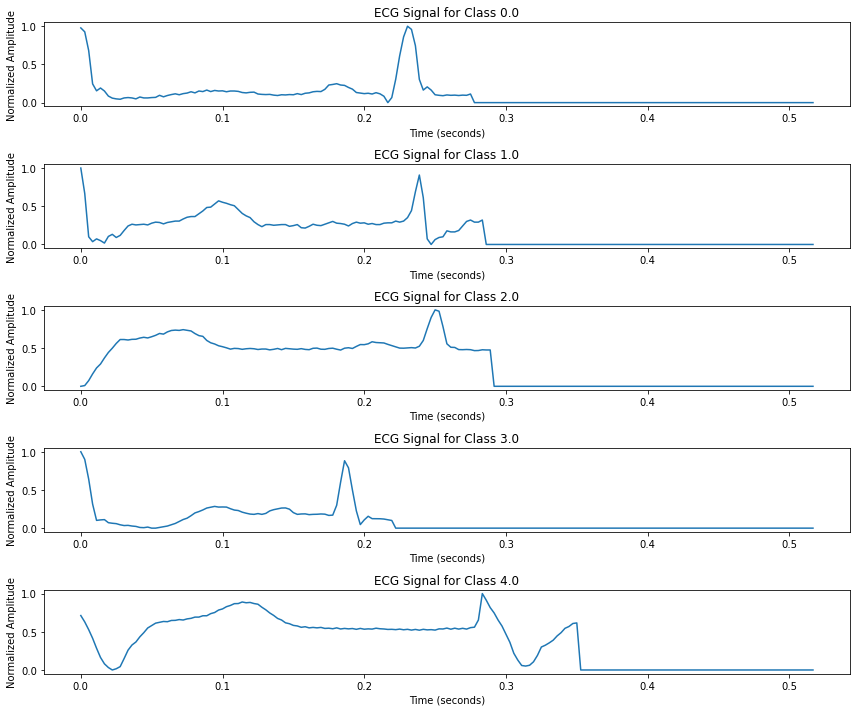

In [ ]:
# Plotting the points to form ecg signals for each class separately

# Sampling rate - number of samples per second (as per the data card)
sampling_rate = 360

# Limiting the number of samples plotted for each class to manage resource usage
sample_limit = 1000

# Creating a figure and axes for 5 plots
fig, axs = plt.subplots(5, 1, figsize=(12, 10))

classes = sorted(train_df.iloc[:, -1].unique())  # Sorting unique classes

for i, cls in enumerate(classes):
    # Filtering the DataFrame for the current class and selecting the first record
    class_df = train_df[train_df.iloc[:, -1] == cls]

    if not class_df.empty:
        record = class_df.iloc[0, :-1].values  # Getting the ECG values

        # If the record is longer than our sample limit, truncate it
        if len(record) > sample_limit:
            record = record[:sample_limit]

        time_seconds = np.arange(len(record)) / sampling_rate  # Time in seconds

        # Plotting the ECG signal for the current class
        axs[i].plot(time_seconds, record)
        axs[i].set_title(f'ECG Signal for Class {cls}')
        axs[i].set_xlabel('Time (seconds)')
        axs[i].set_ylabel('Normalized Amplitude')

plt.tight_layout()
plt.show()

This dataset is classified into five arrhythmia types as seen from the visualization:
- Normal (N) - 0
- Supraventricular ectopic beat (S) - 1
- Ventricular ectopic beat (V) - 2
- Fusion beats (F) - 3  
- Unclassified beats (Q) - 4

#### Dealing with Class Imbalance

In [ ]:
# Calculating the number of records for each class in the dataset
class_distribution = train_df.iloc[:, -1].value_counts()

# Print the class distribution
print(class_distribution)

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


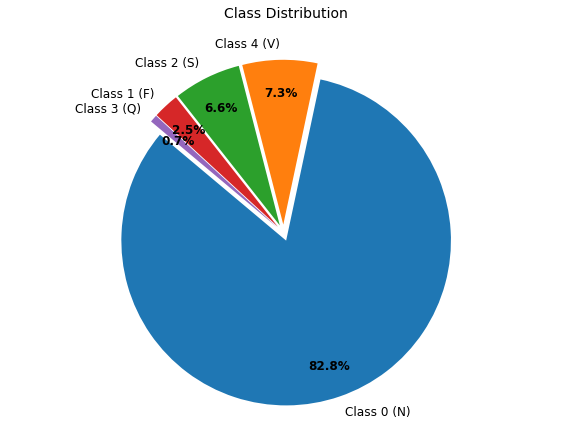

In [ ]:
# Define labels for the pie chart
labels = ['Class 0 (N)', 'Class 4 (V)', 'Class 2 (S)', 'Class 1 (F)', 'Class 3 (Q)']

# Create a pie chart
fig, ax = plt.subplots(figsize=(10, 7))  # Increase figure size
wedges, texts, autotexts = ax.pie(class_distribution, labels=labels, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.8, explode=(0.05, 0.05, 0.05, 0.05, 0.05))

# Equal aspect ratio ensures the pie chart is circular.
ax.axis('equal')

# Enhance the labels and percentages font size and color
plt.setp(texts, size=12, color="black")
plt.setp(autotexts, size=12, color="black", weight="bold")

# Add a title with increased font size
ax.set_title('Class Distribution', fontsize=14, y=1.05)

plt.show()

As we can see, there is huge class imbalance problem with the dataset. Although preserving the originality of the data is important in healthcare datasets, specifically in this ECG dataset, it is also very important that the model predicts the different arrythmia types. From a clinical perspective, accurately predicting classes 2 (Ventricular ectopic beat), 1 (Supraventricular ectopic beat), and 3 (Fusion Beat) is crucial due to their potential indication of heart disease. Thus, dealing with this class imbalance thoughtfully is important.

In [4]:
# Splitting the train_df into training and validation sets before dealing with imbalance to keep the validation set untouched and unseen

from sklearn.model_selection import train_test_split

X = train_df.iloc[:, :-1].values  # Select all columns except the last as features
y = train_df.iloc[:, -1].values   # Select the last column as labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Also splitting the test set into X_test and y_test
X_test = test_df.iloc[:, :-1]  # Select all columns except the last one for features
y_test = test_df.iloc[:, -1]   # Select the last column for labels

In addressing class imbalance, a combined strategy of undersampling and SMOTE was employed. Undersampling the majority classes minimizes computational demands and prevents the overshadowing of minority classes. Meanwhile, applying SMOTE to underrepresented classes enhances their presence without excessively relying on synthetic data.

In [5]:
# Distribution of y_train after splitting training set into training and validation
pd.DataFrame(y_train).value_counts()

0.0    57892
4.0     5182
2.0     4676
1.0     1797
3.0      496
dtype: int64

- Applying SMOTE to produce synthetic data for under represented classes

In [6]:
# SMOTE strategy to make minority classes up to 20000 samples
smote_strategy = {1: 20000, 2: 20000, 3: 20000, 4: 20000}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# New class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution after SMOTE: Counter({0.0: 57892, 2.0: 20000, 4.0: 20000, 1.0: 20000, 3.0: 20000})


- Applying Random Downsampling to the majority class

In [7]:
# Downsampling strategy to make all classes to 20000 samples
downsampling_strategy = {0: 20000, 1: 20000, 2: 20000, 3: 20000, 4: 20000}
under_sampler = RandomUnderSampler(sampling_strategy=downsampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_smote, y_train_smote)

# New class distribution after SMOTE and downsampling
print("Class distribution after SMOTE and downsampling:", Counter(y_train_resampled))

Class distribution after SMOTE and downsampling: Counter({0.0: 20000, 1.0: 20000, 2.0: 20000, 3.0: 20000, 4.0: 20000})


In [8]:
# Keeping the distribution of validation and test sets as it is to maintain the originality of the results
pd.DataFrame(y_val).value_counts()

0.0    14579
4.0     1249
2.0     1112
1.0      426
3.0      145
dtype: int64

Training with SMOTE and downsampled set helps the model learn from a balanced perspective, but evaluating on an imbalanced set checks if the model can still recognize minority classes effectively despite their lower representation.

- Converting the datatype to tensor for training purposes

In [9]:
# Training set
X_train_tensor = torch.tensor(np.array(X_train_resampled))
y_train_tensor = torch.tensor(np.array(y_train_resampled))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Validation set
X_val_tensor = torch.tensor(np.array(X_val))
y_val_tensor = torch.tensor(np.array(y_val))
validate_dataset = TensorDataset(X_val_tensor, y_val_tensor)
validate_dataloader = DataLoader(validate_dataset, batch_size=64, shuffle=True)

# Test set
X_test_tensor = torch.tensor(np.array(X_test))
y_test_tensor = torch.tensor(np.array(y_test))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# Save the test dataset tensors for future use
torch.save(X_test_tensor, 'X_test_tensor.pth')
torch.save(y_test_tensor, 'y_test_tensor.pth')

The data is already standardised and doesn't have any missing values, so our next step is training the model using two different NECO methods, that is SVM and LSTM and then compare the performances of both the models on the test set, keeping the accuracy got using MLP (in group coursework) as a baseline.


## **RNN : LSTM**

#### 1) Initialization of LSTM network

In [12]:
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html 
import torch
import torch.nn as nn

# with learnable initializations
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout= dropout_rate)

        # Defining fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Learnable initial hidden and cell states
        # As training progresses, learnable initial states can evolve in a way that helps the
        # model minimize the loss function more effectively.(rather than setting them to 0)
        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))
        self.c0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))
        
#  when expanding the initial states h0 and c0 to match the batch size of x, we're essentially ensuring 
# that each sequence in the batch has its own initial state. 
    def forward(self, x):
        # Expand learnable initial states to the batch size of x
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        c0 = self.c0.expand(-1, x.size(0), -1).contiguous().to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step for classification task
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Assigning the space to save the best model for lstm
import os

# Define the path for saving the best model
best_model_path = '/content/drive/My Drive/Best Model/'

# Check if the directory exists, if not, create it
best_model_dir = os.path.dirname(best_model_path)
if not os.path.exists(best_model_dir):
    os.makedirs(best_model_dir)

#### 2) Training the model with different set of hyperparameters to get the results from best combinations

- **Iteration 1**

In [ ]:
# Iteration 1
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization with basic parameters to get baseline model for LSTM
input_size = 1  # The number of features per time step
hidden_size = 128  # The number of features in the hidden state of the LSTM
num_layers = 2  # The number of stacked LSTM layers
output_size = 5  # The number of output classes
dropout_rate = 0 # setting the dropout rate as 0 for baseline

# Defining model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
model.to(device)

# We are not particularly applying an activation function (Softmax) because
# nn.CrossEntropyLoss() as loss function in PyTorch internally applies combines
# nn.LogSoftmax() and nn.NLLLoss() (negative log likelihood loss) in one single class.
criterion = nn.CrossEntropyLoss()

# Optimizer setup. Adam is used here because it generally requires less configuration
# and adapts the learning rate for each parameter for more efficient training with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Early stopping setup to prevent overfitting
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Lists to store performance metrics
training_losses1 = []
validation_losses1 = []
training_accuracies1 = []
validation_accuracies1 = []

n_epochs = 100

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Loop over each batch in the training set
    for inputs, labels in train_dataloader:
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        inputs = inputs.view(-1, 187, 1) 
        # Reshaping inputs to [batch_size(64), seq_len(187), features(1)] to fit lstm model
        optimizer.zero_grad()   # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Computing the loss
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update model weights
        total_loss += loss.item()  # Accumulate total loss

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    training_accuracy = correct_predictions / total_predictions
    training_losses1.append(total_loss / len(train_dataloader))
    training_accuracies1.append(training_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_dataloader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            inputs = inputs.view(-1, 187, 1)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_accuracy = correct / total
    validation_losses1.append(val_loss / len(validate_dataloader))
    validation_accuracies1.append(val_accuracy)

    print(f'Epoch {epoch}/{n_epochs}, Training Loss: {training_losses1[-1]:.4f}, 
          Training Accuracy: {training_accuracies1[-1]:.4f}, Validation Loss: {validation_losses1[-1]:.4f}, 
          Validation Accuracy: {validation_accuracies1[-1]:.4f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        Iteration_1_path = '/content/drive/My Drive/Colab Notebooks/Neural Computing/Best Model/iteration1.pth'
        # Save the best model
        torch.save(model.state_dict(), Iteration_1_path)

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

Epoch 1/100, Training Loss: 1.6121, Training Accuracy: 0.2076, Validation Loss: 1.6528, Validation Accuracy: 0.0668
Epoch 2/100, Training Loss: 1.6101, Training Accuracy: 0.1999, Validation Loss: 1.6041, Validation Accuracy: 0.0260
Epoch 3/100, Training Loss: 1.6100, Training Accuracy: 0.1934, Validation Loss: 1.6089, Validation Accuracy: 0.0668
Epoch 4/100, Training Loss: 1.6104, Training Accuracy: 0.1993, Validation Loss: 1.6523, Validation Accuracy: 0.0260
Epoch 5/100, Training Loss: 1.6102, Training Accuracy: 0.1961, Validation Loss: 1.6119, Validation Accuracy: 0.0069
Epoch 6/100, Training Loss: 1.6104, Training Accuracy: 0.1983, Validation Loss: 1.6578, Validation Accuracy: 0.0069
Epoch 7/100, Training Loss: 1.6103, Training Accuracy: 0.2010, Validation Loss: 1.6218, Validation Accuracy: 0.0260
Epoch 8/100, Training Loss: 1.6101, Training Accuracy: 0.1988, Validation Loss: 1.5884, Validation Accuracy: 0.8427
Epoch 9/100, Training Loss: 1.6099, Training Accuracy: 0.1991, Validatio

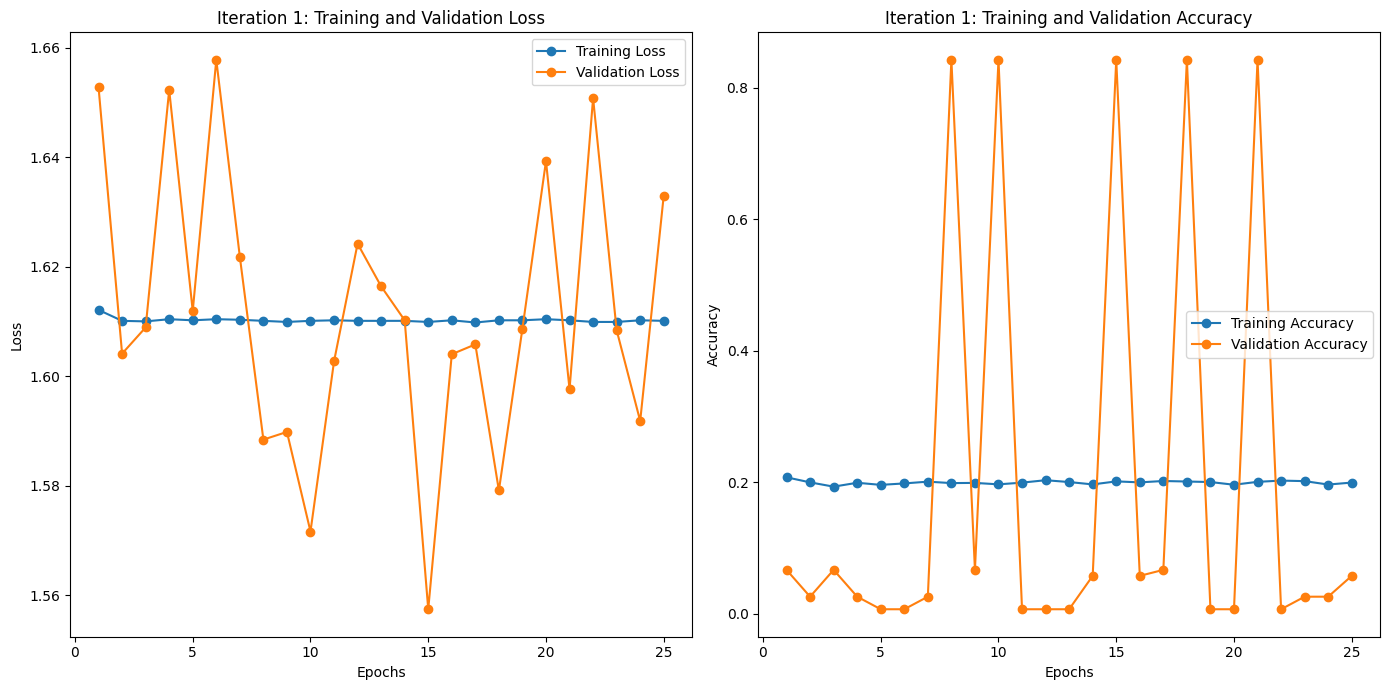

In [ ]:
# Plotting training and validation loss and accuracy for ITERATION 1

epochs = range(1, len(training_losses1) + 1)

plt.figure(figsize=(14, 7))

# Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses1, 'o-', label='Training Loss')
plt.plot(epochs, validation_losses1, 'o-', label='Validation Loss')
plt.title('Iteration 1: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies1, 'o-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies1, 'o-', label='Validation Accuracy')
plt.title('Iteration 1: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Iteration 1: The Baseline Model**

The initial iteration served as the baseline, employing a relatively straightforward configuration:
- **Hidden Neurons:** 128
- **Layers:** 2
- **Learning Rate:** 0.01
- **Dropout Rate:** 0

Iteration 1 established a baseline with its simple configuration, but the actual performance revealed significant issues. Despite maintaining a consistent training accuracy and loss across all epochs, the validation metrics showed considerable volatility. The high learning rate and setting the dropout to 0 contributed to these erratic fluctuations, making the model prone to overshoot optimal minima within the loss landscape. This configuration's lack of dropout further exacerbated the risk of overfitting, as evidenced by the wide swings in validation performance. This stark contrast between the training stability and validation variability highlighted the need for adjustments in the model's learning dynamics and complexity.

- **Iteration 2**

In [ ]:
# Iteration 2
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization for Iteration 2 with adjustments in layers and learning rate
input_size = 1
hidden_size = 128  # keeping the number of hidden neurons same
num_layers = 3  # increasing the number of stacked LSTM layers
output_size = 5    # 5 class output
dropout_rate = 0.2  # increasing the dropout rate to 0.2

# Initializing the LSTM model with dropout
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
model.to(device)

# Criterion using nn.CrossEntropyLoss which combines nn.LogSoftmax() and nn.NLLLoss in one class
criterion = nn.CrossEntropyLoss()

# Optimizer with adjusted learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup to prevent overfitting
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Lists to store performance metrics for iteration 2
training_losses2 = []
validation_losses2 = []
training_accuracies2 = []
validation_accuracies2 = []

n_epochs = 100

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Loop over each batch in the training set
    for inputs, labels in train_dataloader:
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        inputs = inputs.view(-1, 187, 1)  # Reshaping inputs for the LSTM model
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Computing the loss
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update model weights
        total_loss += loss.item()  # Accumulate total loss

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    training_accuracy = correct_predictions / total_predictions
    training_losses2.append(total_loss / len(train_dataloader))
    training_accuracies2.append(training_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_dataloader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            inputs = inputs.view(-1, 187, 1)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_accuracy = correct / total
    validation_losses2.append(val_loss / len(validate_dataloader))
    validation_accuracies2.append(val_accuracy)

    print(f'Epoch {epoch}/{n_epochs}, Training Loss: {training_losses2[-1]:.4f}, 
          Training Accuracy: {training_accuracies2[-1]:.4f}, Validation Loss: {validation_losses2[-1]:.4f}, 
          Validation Accuracy: {validation_accuracies2[-1]:.4f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        Iteration_2_path = '/content/drive/My Drive/Colab Notebooks/Neural Computing/Best Model/iteration2.pth'
        # Save the best model
        torch.save(model.state_dict(), Iteration_2_path)

    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

Epoch 1/100, Training Loss: 1.3084, Training Accuracy: 0.4237, Validation Loss: 1.2655, Validation Accuracy: 0.4779
Epoch 2/100, Training Loss: 0.8023, Training Accuracy: 0.7036, Validation Loss: 0.8986, Validation Accuracy: 0.6821
Epoch 3/100, Training Loss: 0.5030, Training Accuracy: 0.8153, Validation Loss: 0.5140, Validation Accuracy: 0.8229
Epoch 4/100, Training Loss: 0.4337, Training Accuracy: 0.8451, Validation Loss: 0.5478, Validation Accuracy: 0.8159
Epoch 5/100, Training Loss: 0.2875, Training Accuracy: 0.8958, Validation Loss: 0.4079, Validation Accuracy: 0.8541
Epoch 6/100, Training Loss: 0.2510, Training Accuracy: 0.9110, Validation Loss: 0.4120, Validation Accuracy: 0.8503
Epoch 7/100, Training Loss: 0.2170, Training Accuracy: 0.9224, Validation Loss: 0.5276, Validation Accuracy: 0.8097
Epoch 8/100, Training Loss: 0.1935, Training Accuracy: 0.9320, Validation Loss: 0.3256, Validation Accuracy: 0.8794
Epoch 9/100, Training Loss: 0.2307, Training Accuracy: 0.9180, Validatio

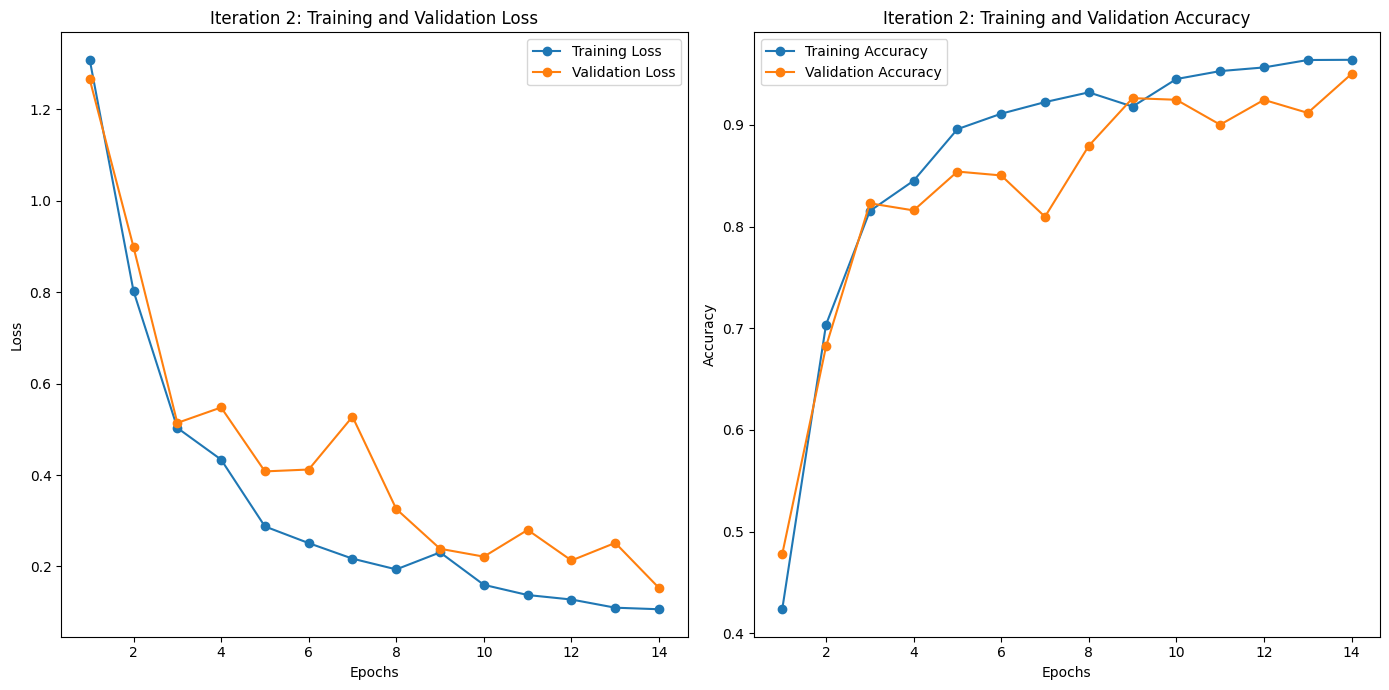

In [ ]:
# Line graphs for validation and training accuracy and loss for ITERATION 2

epochs = range(1, len(training_losses2) + 1)

plt.figure(figsize=(14, 7))

# Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses2, 'o-', label='Training Loss')
plt.plot(epochs, validation_losses2, 'o-', label='Validation Loss')
plt.title('Iteration 2: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies2, 'o-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies2, 'o-', label='Validation Accuracy')
plt.title('Iteration 2: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Iteration 2: Increased Complexity**

To address the limitations observed in Iteration 1 and enhance the model's capacity for learning sequential data representations, the following adjustments are made for Iteration 2:
- **Hidden Neurons:** Remained at 128
- **Layers:** Increased to 3
- **Learning Rate:** Reduced to 0.001
- **Dropout Rate:** increased to 0.2

After implementing changes in Iteration 2, the performance of the model improved significantly, as observed in the graph. The addition of an extra layer allowed the model to capture more complex patterns in the data, reflected by the steadily decreasing loss and increasing accuracy across epochs. Although there were minor fluctuations in validation performance, these were substantially reduced compared to Iteration 1, indicating a more stable model. The reduction in learning rate and the increase in dropout to 0.2 contributed to this stability, enhancing the precision of weight adjustments.
Despite these enhancements, the model can be further refined.

- **Iteration 3**

In [ ]:
# Iteration 3
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization with updated parameters for Iteration 3
input_size = 1
hidden_size = 256  # Increased hidden size
num_layers = 2  # Reducing the number of layers back to 2
output_size = 5
dropout_rate = 0.2  # keeping drop rate as it is from iteration2

# Defining model 
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
model.to(device)
criterion = nn.CrossEntropyLoss()
# Keeping the learning rate constant like in iteration 2
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup to prevent overfitting
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Lists to store performance metrics
training_losses3 = []
validation_losses3 = []
training_accuracies3 = []
validation_accuracies3 = []

n_epochs = 100

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Loop over each batch in the training set
    for inputs, labels in train_dataloader:
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        inputs = inputs.view(-1, 187, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    training_accuracy = correct_predictions / total_predictions
    training_losses3.append(total_loss / len(train_dataloader))
    training_accuracies3.append(training_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_dataloader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            inputs = inputs.view(-1, 187, 1)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_accuracy = correct / total
    validation_losses3.append(val_loss / len(validate_dataloader))
    validation_accuracies3.append(val_accuracy)

    print(f'Epoch {epoch}/{n_epochs}, Training Loss: {training_losses3[-1]:.4f}, 
          Training Accuracy: {training_accuracies3[-1]:.4f}, Validation Loss: {validation_losses3[-1]:.4f},
          Validation Accuracy: {validation_accuracies3[-1]:.4f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        Iteration_3_path = '/content/drive/My Drive/Colab Notebooks/Neural Computing/Best Model/iteration3.pth'
        # Save the best model
        torch.save(model.state_dict(), Iteration_3_path)

    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

Epoch 1/100, Training Loss: 1.4302, Training Accuracy: 0.3470, Validation Loss: 1.4387, Validation Accuracy: 0.2946
Epoch 2/100, Training Loss: 0.9348, Training Accuracy: 0.6396, Validation Loss: 0.9092, Validation Accuracy: 0.6245
Epoch 3/100, Training Loss: 0.6079, Training Accuracy: 0.7760, Validation Loss: 0.5110, Validation Accuracy: 0.8447
Epoch 4/100, Training Loss: 0.3628, Training Accuracy: 0.8730, Validation Loss: 0.4094, Validation Accuracy: 0.8898
Epoch 5/100, Training Loss: 0.2858, Training Accuracy: 0.8995, Validation Loss: 0.3297, Validation Accuracy: 0.8989
Epoch 6/100, Training Loss: 0.2244, Training Accuracy: 0.9223, Validation Loss: 0.3507, Validation Accuracy: 0.8781
Epoch 7/100, Training Loss: 0.1919, Training Accuracy: 0.9330, Validation Loss: 0.2762, Validation Accuracy: 0.8988
Epoch 8/100, Training Loss: 0.1653, Training Accuracy: 0.9430, Validation Loss: 0.1975, Validation Accuracy: 0.9325
Epoch 9/100, Training Loss: 0.1427, Training Accuracy: 0.9503, Validatio

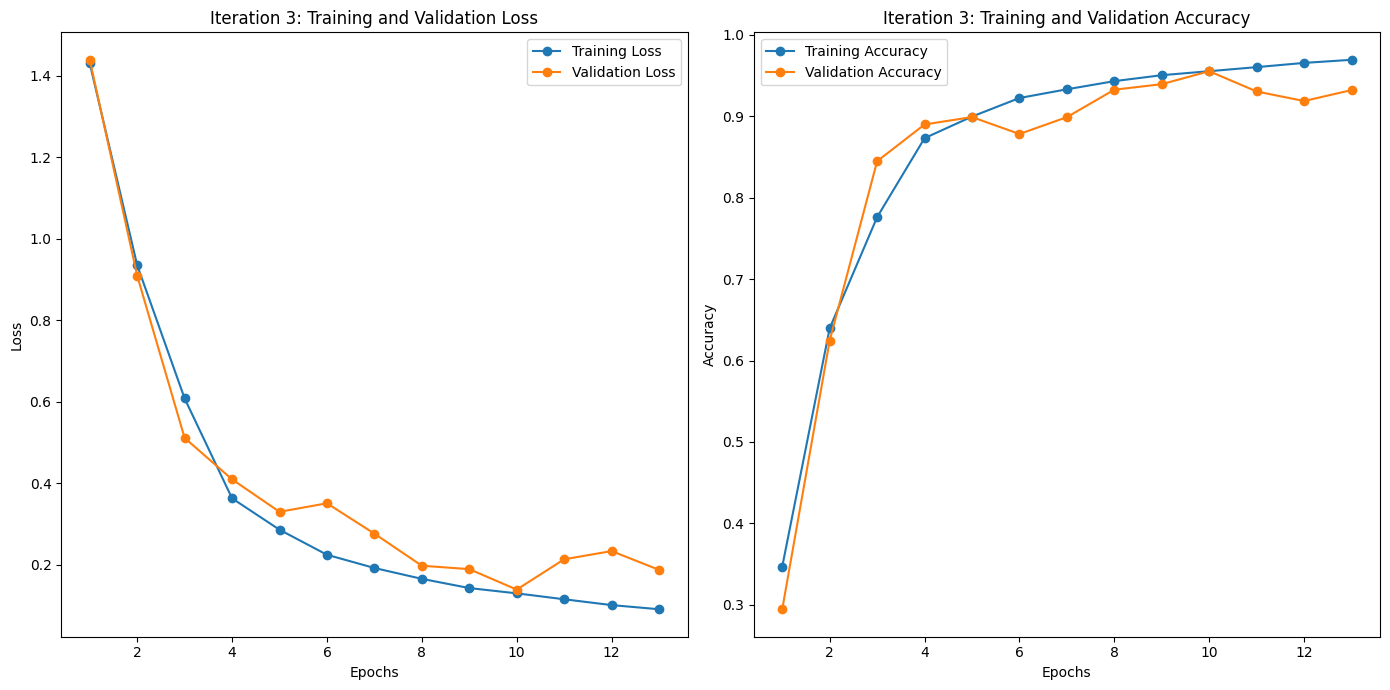

In [ ]:
# Line graphs for training and validation loss and accuracy for ITERATION 3

epochs = range(1, len(training_losses3) + 1)

plt.figure(figsize=(14, 7))

# Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses3, 'o-', label='Training Loss')
plt.plot(epochs, validation_losses3, 'o-', label='Validation Loss')
plt.title('Iteration 3: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies3, 'o-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies3, 'o-', label='Validation Accuracy')
plt.title('Iteration 3: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Iteration 3: Enhanced Model Capacity**

The third iteration sought to further refine the model by adjusting its architecture to balance capacity and complexity optimally:
- **Hidden Neurons:** Increased to 256
- **Layers:** Reduced back to 2
- **Learning Rate:** Maintained at 0.001
- **Dropout Rate:** Maintained at 0.2

Building on the adjustments made in Iteration 2, Iteration 3 successfully refined the model's capabilities by increasing the number of hidden neurons to 256 and reducing the network back to two layers. This balance was aimed at enhancing the model's capacity to capture complex and high features without the complexities associated with deeper networks, which could potentially lead to issues like vanishing gradients. The consistent dropout rate of 0.2 continued to help mitigate overfitting by encouraging a more generalized learning process. These modifications led to a noticeable improvement in model performance, as depicted in the graph, showing enhanced learning depth and robust feature representation under diverse conditions.

Comparative line graph for iteration 2 and 3

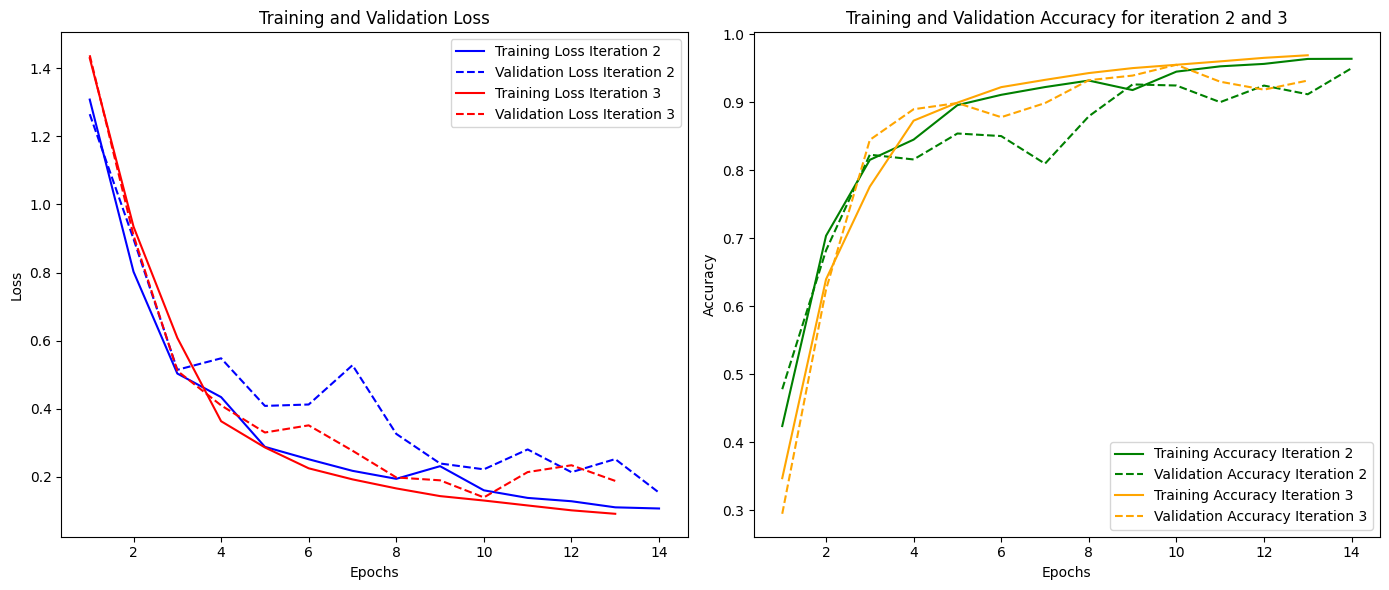

In [ ]:
epochs2 = range(1, len(training_losses2) + 1)
epochs3 = range(1, len(training_losses3) + 1)

plt.figure(figsize=(14, 7))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(epochs2, training_losses2, label='Training Loss Iteration 2', color='blue')
plt.plot(epochs2, validation_losses2, label='Validation Loss Iteration 2', color='blue', linestyle='dashed')
plt.plot(epochs3, training_losses3, label='Training Loss Iteration 3', color='red')
plt.plot(epochs3, validation_losses3, label='Validation Loss Iteration 3', color='red', linestyle='dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs2, training_accuracies2, label='Training Accuracy Iteration 2', color='green')
plt.plot(epochs2, validation_accuracies2, label='Validation Accuracy Iteration 2', color='green', linestyle='dashed')
plt.plot(epochs3, training_accuracies3, label='Training Accuracy Iteration 3', color='orange')
plt.plot(epochs3, validation_accuracies3, label='Validation Accuracy Iteration 3', color='orange', linestyle='dashed')
plt.title('Training and Validation Accuracy for Iterations 2 and 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Comparative Analysis and Conclusion**

Iteration 3 proved the most effective, outperforming others with its fine-tuned balance of model capacity and complexity. With 256 hidden neurons, it efficiently learned data patterns, while two layers avoided deep network issues like vanishing gradients and overfitting. This balance led to better generalization on validation set.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 3) Implementing the best combination of hyperparameters obtained from the iterations on test set

In [59]:
# Initializing the LSTM model for testing exactly like did in the training
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

        # Including the learnable initial states in the model like did in the training
        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))
        self.c0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))

    def forward(self, x):
        # Expand initial states to the batch size of x
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous()
        c0 = self.c0.expand(-1, x.size(0), -1).contiguous()

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0.to(x.device), c0.to(x.device)))
        out = self.fc(out[:, -1, :])
        return out

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the best model weights and biases and the best hyperparameters and architecture from iteration 3
bestmodel_lstm_path = '/content/drive/My Drive/Colab Notebooks/Neural Computing/Best Model/iteration3.pth'
bestmodel_lstm = LSTMModel(input_size=1, hidden_size=256, num_layers=2, output_size=5, dropout_rate=0.2).to(device)
bestmodel_lstm.load_state_dict(torch.load(bestmodel_path))

# Switch model to evaluation mode
bestmodel_lstm.eval() # Setting the model to evaluation mode
y_pred = []  # To store all predictions
y_true = []  # To store all true labels

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        inputs = inputs.view(-1, 187, 1)
        outputs = bestmodel_lstm(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())
        
# Generate the classification report and overall accuracy
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(5)]))
print("Accuracy on Test Set from Best LSTM Model: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))

              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98     18118
     Class 1       0.55      0.82      0.66       556
     Class 2       0.91      0.94      0.93      1448
     Class 3       0.62      0.83      0.71       162
     Class 4       0.96      0.98      0.97      1608

    accuracy                           0.96     21892
   macro avg       0.81      0.91      0.85     21892
weighted avg       0.97      0.96      0.97     21892

Accuracy on Test Set from Best LSTM Model: 96.30%


<!-- saving these intermediate results as a dataframe

Epoch 1/500, Training Loss: 1.30, Validation Loss: 1.07, Validation Accuracy: 0.21, Validation F1 Score: 0.25
Epoch 2/500, Training Loss: 0.76, Validation Loss: 1.16, Validation Accuracy: 0.45, Validation F1 Score: 0.54
Epoch 3/500, Training Loss: 1.61, Validation Loss: 1.61, Validation Accuracy: 0.06, Validation F1 Score: 0.01
Epoch 4/500, Training Loss: 1.60, Validation Loss: 1.85, Validation Accuracy: 0.11, Validation F1 Score: 0.08
Epoch 5/500, Training Loss: 1.61, Validation Loss: 1.71, Validation Accuracy: 0.06, Validation F1 Score: 0.01
Epoch 6/500, Training Loss: 1.61, Validation Loss: 1.75, Validation Accuracy: 0.17, Validation F1 Score: 0.18
Epoch 7/500, Training Loss: 1.60, Validation Loss: 1.60, Validation Accuracy: 0.05, Validation F1 Score: 0.02
Epoch 8/500, Training Loss: 0.96, Validation Loss: 1.19, Validation Accuracy: 0.48, Validation F1 Score: 0.58
Epoch 9/500, Training Loss: 0.70, Validation Loss: 0.85, Validation Accuracy: 0.62, Validation F1 Score: 0.70
Epoch 10/500, Training Loss: 1.14, Validation Loss: 1.36, Validation Accuracy: 0.13, Validation F1 Score: 0.09
Epoch 11/500, Training Loss: 0.79, Validation Loss: 0.78, Validation Accuracy: 0.67, Validation F1 Score: 0.74
Epoch 12/500, Training Loss: 0.83, Validation Loss: 1.12, Validation Accuracy: 0.44, Validation F1 Score: 0.54
Epoch 13/500, Training Loss: 0.82, Validation Loss: 0.74, Validation Accuracy: 0.71, Validation F1 Score: 0.77
Epoch 14/500, Training Loss: 0.65, Validation Loss: 1.47, Validation Accuracy: 0.20, Validation F1 Score: 0.18
Epoch 15/500, Training Loss: 0.73, Validation Loss: 1.43, Validation Accuracy: 0.34, Validation F1 Score: 0.41
Epoch 16/500, Training Loss: 0.65, Validation Loss: 0.69, Validation Accuracy: 0.80, Validation F1 Score: 0.84
Epoch 17/500, Training Loss: 0.55, Validation Loss: 0.61, Validation Accuracy: 0.81, Validation F1 Score: 0.84
Epoch 18/500, Training Loss: 0.48, Validation Loss: 0.72, Validation Accuracy: 0.72, Validation F1 Score: 0.78
Epoch 19/500, Training Loss: 0.45, Validation Loss: 0.60, Validation Accuracy: 0.81, Validation F1 Score: 0.85
Epoch 20/500, Training Loss: 0.43, Validation Loss: 0.54, Validation Accuracy: 0.84, Validation F1 Score: 0.87
Epoch 21/500, Training Loss: 0.40, Validation Loss: 0.71, Validation Accuracy: 0.78, Validation F1 Score: 0.82
Epoch 22/500, Training Loss: 0.39, Validation Loss: 0.40, Validation Accuracy: 0.88, Validation F1 Score: 0.90
Epoch 23/500, Training Loss: 0.44, Validation Loss: 0.68, Validation Accuracy: 0.76, Validation F1 Score: 0.80
Epoch 24/500, Training Loss: 0.42, Validation Loss: 0.69, Validation Accuracy: 0.74, Validation F1 Score: 0.80
Epoch 25/500, Training Loss: 0.36, Validation Loss: 0.55, Validation Accuracy: 0.83, Validation F1 Score: 0.86
Epoch 26/500, Training Loss: 0.33, Validation Loss: 0.33, Validation Accuracy: 0.91, Validation F1 Score: 0.93
Epoch 27/500, Training Loss: 0.31, Validation Loss: 0.40, Validation Accuracy: 0.87, Validation F1 Score: 0.90
Epoch 28/500, Training Loss: 0.30, Validation Loss: 0.31, Validation Accuracy: 0.91, Validation F1 Score: 0.92
Epoch 29/500, Training Loss: 0.29, Validation Loss: 0.29, Validation Accuracy: 0.92, Validation F1 Score: 0.93
Epoch 30/500, Training Loss: 0.28, Validation Loss: 0.54, Validation Accuracy: 0.80, Validation F1 Score: 0.84
Epoch 31/500, Training Loss: 0.27, Validation Loss: 0.32, Validation Accuracy: 0.91, Validation F1 Score: 0.92
Epoch 32/500, Training Loss: 0.27, Validation Loss: 0.34, Validation Accuracy: 0.90, Validation F1 Score: 0.91
Epoch 33/500, Training Loss: 0.59, Validation Loss: 1.09, Validation Accuracy: 0.38, Validation F1 Score: 0.45
Epoch 34/500, Training Loss: 0.86, Validation Loss: 0.88, Validation Accuracy: 0.68, Validation F1 Score: 0.76
Epoch 35/500, Training Loss: 1.60, Validation Loss: 1.47, Validation Accuracy: 0.75, Validation F1 Score: 0.76
Epoch 36/500, Training Loss: 1.18, Validation Loss: 1.29, Validation Accuracy: 0.47, Validation F1 Score: 0.58
Epoch 37/500, Training Loss: 0.72, Validation Loss: 0.80, Validation Accuracy: 0.74, Validation F1 Score: 0.80
Epoch 38/500, Training Loss: 0.62, Validation Loss: 0.70, Validation Accuracy: 0.77, Validation F1 Score: 0.83
Epoch 39/500, Training Loss: 0.58, Validation Loss: 0.71, Validation Accuracy: 0.77, Validation F1 Score: 0.83
Early stopping triggered.

# Convert the list of results to a DataFrame
df_results = pd.DataFrame(results)

# Display or save the DataFrame as needed
df_results  -->

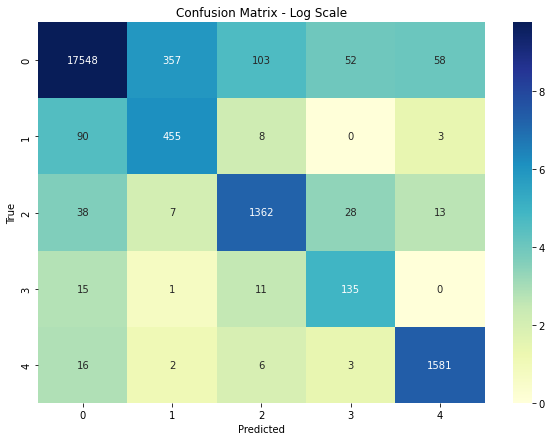

In [20]:
from sklearn.metrics import confusion_matrix

# Calculating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Adding 1 to avoid log(0) error
cm_log_scale = np.log(cm + 1)

# Plot the confusion matrix using Seaborn with log scale
plt.figure(figsize=(10, 7))
sns.heatmap(cm_log_scale, annot=cm, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Log Scale')
plt.show()

This heatmap does not clearly depict the actual performance of the model becuase of the imbalance, thus opting for a normalized heatmap to clearly see the percentage of classes being predicted correctly.

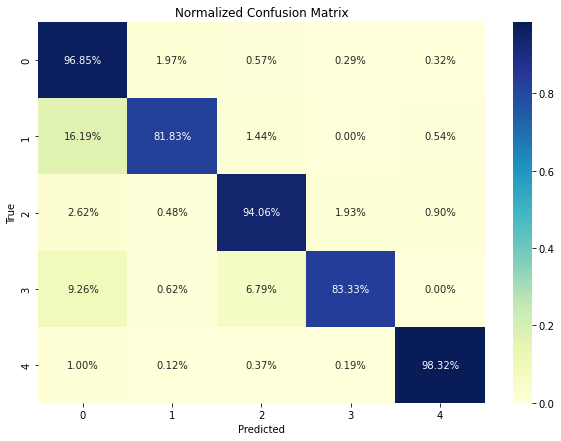

In [21]:
# The normalized confusion matrix will show the proportion of true labels within each class that were correctly identified

# Calculating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by the number of samples in each class
# This function computes the total count of true instances for each class, and then
# each entry in the confusion matrix is divided by this count, resulting in a matrix of percentages.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

The LSTM model achieved an impressive overall accuracy of 96.3% on the test set, demonstrating its strong generalization capabilities. This high performance can be attributed to the iterative tuning process, where we progressively refined the model's architecture and hyperparameters across several iterations. The model's ability to differentiate between the classes with high precision and recall rates underscores its robustness in handling the sequential nature of ECG signals, ensuring accurate and reliable arrhythmia classification.

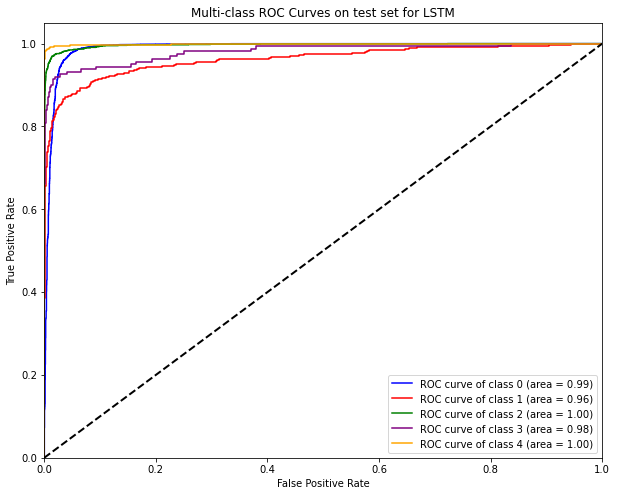

In [24]:
# Creating ROC-AUC curves for all the classes

from sklearn.metrics import roc_curve, auc
bestmodel_lstm.eval()

# Collect all logits and true labels
all_logits = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        inputs = inputs.view(-1, 187, 1)
        logits = bestmodel_lstm(inputs)  # Get raw logits from the model
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
# Convert logits to probabilities
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

probabilities = softmax(all_logits)

from sklearn.preprocessing import label_binarize

# Binarizing the labels for multi-class ROC
n_classes = 5  
y_true = label_binarize(all_labels, classes=np.arange(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves on test set for LSTM')
plt.legend(loc="lower right")
plt.show()

## **SVM**

1) **Feature extraction** = **DWT(Discrete Wavelet Transform)**   transforms raw data into features that reveal arrhythmia patterns. DWT is ideal for ECG analysis as it breaks down signals into frequencies with time details, crucial for identifying arrhythmias marked by frequency changes over time.

In [26]:
import pywt
def dwt_features(data, wavelet='db4', level=3):
    features = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
        # Concatenate the approximation and detail coefficients
        features.append(np.concatenate([coeff.ravel() for coeff in coeffs]))
    return np.array(features)

# Applying DWT feature extraction to the datasets
X_train_dwt = dwt_features(X_train_resampled)  # For training data
X_val_dwt = dwt_features(X_val)  # For validation data
# Convert X_test DataFrame to numpy ndarray
X_test_ndarray = X_test.to_numpy()
# Then apply DWT feature extraction
X_test_dwt = dwt_features(X_test_ndarray)

In [27]:
print(X_train_resampled.shape)
print(X_train_dwt.shape)
print(X_val.shape)
print(X_val_dwt.shape)
print(X_test.shape)
print(X_test_dwt.shape)

(100000, 187)
(100000, 207)
(17511, 187)
(17511, 207)
(21892, 187)
(21892, 207)


 For each dataset, the number of features per sample has increased from 187 to 207 as a result of applying DWT. This increase signifies that the DWT process has extracted additional features from the original ECG signal data.

2) **Feature Scaling :** Before training the SVM model, scaling the DWT-extracted features.

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_dwt_scaled = scaler.fit_transform(X_train_dwt)

In [30]:
# Save the fitted scaler to a file
joblib.dump(scaler, 'C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\scaler.joblib')

['C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\scaler.joblib']

In [31]:
# Load the fitted scaler
scaler_path = 'C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\scaler.joblib'
scaler = joblib.load(scaler_path)

In [32]:
# Performing scaling on the fitted scaler model
X_val_dwt_scaled = scaler.transform(X_val_dwt)
X_test_dwt_scaled = scaler.transform(X_test_dwt)

3) **Applying Principal Component Analysis (PCA):**  to reduce the dimensionality of our dataset to keep the SVM algorithm computationally efficient. This process was skipped during LSTM as it uses the sequential information to predict and using PCA before LSTM would not have given appropriate results and the true strenght of LSTM model

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_dwt_scaled)

In [34]:
# Load the fitted PCA model
joblib.dump(pca, 'C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\pca.joblib')  

['C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\pca.joblib']

In [35]:
# loading the fitted PCA model
pca_path = 'C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\pca.joblib'
pca = joblib.load(pca_path)

In [36]:
# Applying pca using the fitted model
X_val_pca = pca.transform(X_val_dwt_scaled)
X_test_pca = pca.transform(X_test_dwt_scaled)

4) **Training and evaluating SVM model using baseline parameters**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Training the SVM model with a linear kernel and common parameters to get the baseline performance
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model on the scaled training set
svm_model.fit(X_train_pca, y_train_resampled)

# Evaluate the model on the validation set
y_val_pred = svm_model.predict(X_val_pca)

# Print the classification report for detailed performance metrics
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

# print the accuracy score
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Set Accuracy: {accuracy * 100:.2f}%")

Classification Report for Validation Set:
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     14579
         1.0       0.18      0.65      0.29       426
         2.0       0.33      0.79      0.46      1112
         3.0       0.10      0.88      0.18       145
         4.0       0.80      0.90      0.85      1249

    accuracy                           0.73     17511
   macro avg       0.48      0.79      0.52     17511
weighted avg       0.89      0.73      0.78     17511

Validation Set Accuracy: 72.71%


The overall accuracy on the validation set for baseline SVM model is just 72%, with each underrepresented class showing very low precision. This underscores the need of finding the best hyperparameters for SVM via gridsearch.

5) **Grid Search:** On 20% of the data to reduce the computational time taken for finding the best hyperparameters using training set for cross validation

In [ ]:
from sklearn.model_selection import train_test_split

# Using 20% of the data for the grid search
X_train_pca_sample, _, y_train_resampled_sample, _ = train_test_split(
    X_train_pca, y_train_resampled, test_size=0.8, random_state=42, stratify=y_train_resampled
)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV with 5 fold cross validation on 20% of training set focusing on the highest accuracy metric
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)

# Perform grid search on the sampled dataset
grid_search.fit(X_train_pca_sample, y_train_resampled_sample)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  16.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  17.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  17.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  17.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  17.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  27.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  26.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  28.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  27.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  27.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  17.2s
[CV] END ...................C=0.1, gamma=0.01, 

In [56]:
# Getting the mean accuracy for each combination to check the best parameters found with their mean accuracy values
# Access the cv_results_ dictionary as the gridsearch was based on accuracy performance of the validation set
cv_results = grid_search.cv_results_

# Print the mean test score for each parameter combination
for i in range(len(cv_results['params'])):
    print(f"Parameters: {cv_results['params'][i]} - Mean Test Accuracy: {cv_results['mean_test_score'][i]:.4f}")

Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} - Mean Test Accuracy: 0.7975
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} - Mean Test Accuracy: 0.8167
Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'} - Mean Test Accuracy: 0.7975
Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'} - Mean Test Accuracy: 0.8130
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'} - Mean Test Accuracy: 0.7975
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'} - Mean Test Accuracy: 0.4111
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'} - Mean Test Accuracy: 0.7975
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} - Mean Test Accuracy: 0.2338
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} - Mean Test Accuracy: 0.8007
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} - Mean Test Accuracy: 0.9046
Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'} - Mean Test Accuracy: 0.8007
Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} - Mean 

6) **Training and evaluating the SVM model**:  with the best hyperparameters found via GridSearch

In [42]:
# Extracting the best hyperparameters
best_params = grid_search.best_params_

# Initialize the SVM model with the best hyperparameters setting the probability True for roc curves
svm_best = SVC(**best_params, probability=True, random_state=42)

# Train the model on the entire PCA-transformed training set
svm_best.fit(X_train_pca, y_train_resampled)

# Evaluate the model on the PCA-transformed validation set
y_val_pred_best = svm_best.predict(X_val_pca)

# Print the classification report for detailed performance metrics
print("Classification Report for Validation Set with SVM Best Hyperparameters:")
print(classification_report(y_val, y_val_pred_best))

# Print the accuracy score
accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f"Validation Set Accuracy with SVM Best Hyperparameters: {accuracy_best * 100:.2f}%")

Classification Report for Validation Set with SVM Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     14579
         1.0       0.68      0.61      0.64       426
         2.0       0.86      0.83      0.84      1112
         3.0       0.74      0.77      0.75       145
         4.0       0.97      0.96      0.97      1249

    accuracy                           0.96     17511
   macro avg       0.84      0.83      0.84     17511
weighted avg       0.96      0.96      0.96     17511

Validation Set Accuracy with SVM Best Hyperparameters: 95.86%


After performing grid search for hyperparameter tuning, the SVM model's performance on the validation set saw a remarkable increase of nearly 15%, showcasing the effectiveness of precise model optimization.

7) **Saving & Testing the Best Model for SVM**

In [45]:
# Saving the best model
# Best model from grid search
bestmodel_svm = grid_search.best_estimator_
filename = 'C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\bestmodel_svm_probab.joblib'
joblib.dump(bestmodel_svm, filename)

['C:\\Users\\FIDVI FATEMA\\OneDrive\\Desktop\\Neural Computing\\ecg dataset\\Best Model SVM\\bestmodel_svm_probab.joblib']

In [46]:
bestmodel_svm = joblib.load(filename)
y_test_pred_svm = bestmodel_svm.predict(X_test_pca)
# Evaluate performance
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred_svm))
print("Accuracy on Test Set from SVM best model: {:.2f}%"
      .format(accuracy_score(y_test, y_test_pred_svm) * 100))

Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96     18118
         1.0       0.41      0.65      0.50       556
         2.0       0.71      0.86      0.78      1448
         3.0       0.42      0.78      0.55       162
         4.0       0.94      0.95      0.94      1608

    accuracy                           0.92     21892
   macro avg       0.69      0.83      0.75     21892
weighted avg       0.94      0.92      0.93     21892

Accuracy on Test Set from SVM best model: 92.26%


SVM's performance for ECG classification test set suggests its suitability for this task, highlighting the importance of spatial patterns extracted by DWT and PCA over LSTM's temporal analysis.
Additionally, SVM's accuracy boost from grid search hyperparameter optimization, a process not as feasible for LSTM due to computational limits, underscores its advantage.

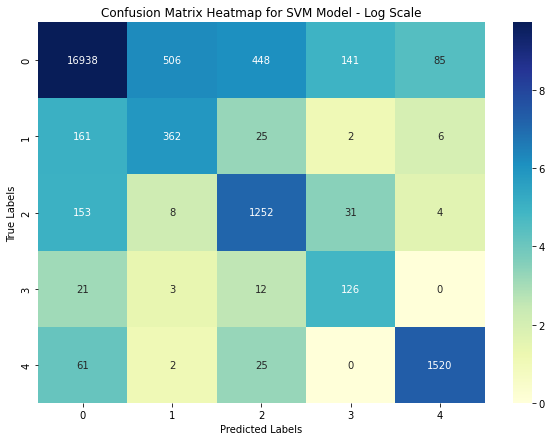

In [54]:
# Generate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)

# Apply log scaling to the confusion matrix to enhance visual representation; add 1 to avoid log(0)
conf_matrix_svm_log = np.log(conf_matrix_svm + 1)

# Plotting the heatmap for SVM model's confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_svm_log, annot=conf_matrix_svm, fmt='d', cmap='YlGnBu', cbar=True) 
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap for SVM Model - Log Scale')
plt.show()

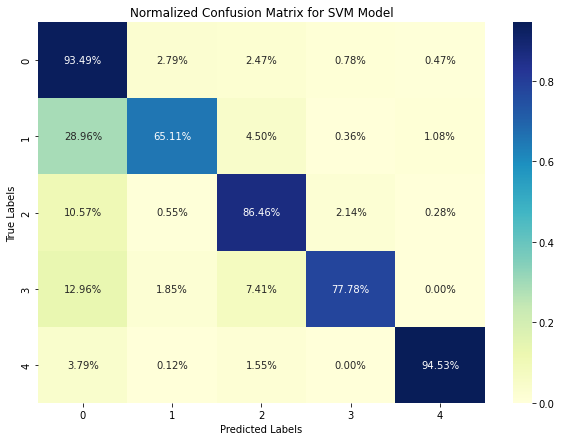

In [55]:
# Generate the confusion matrix for the SVM model
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)

# Normalize the confusion matrix to show the proportion of true labels 
# within each class that were correctly identified. This creates a matrix
#of percentages, showing the performance of the model on a per-class basis
conf_matrix_svm_normalized = conf_matrix_svm.astype('float') 
/ conf_matrix_svm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_svm_normalized, annot=True, fmt='.2%', cmap='YlGnBu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix for SVM Model')
plt.show()

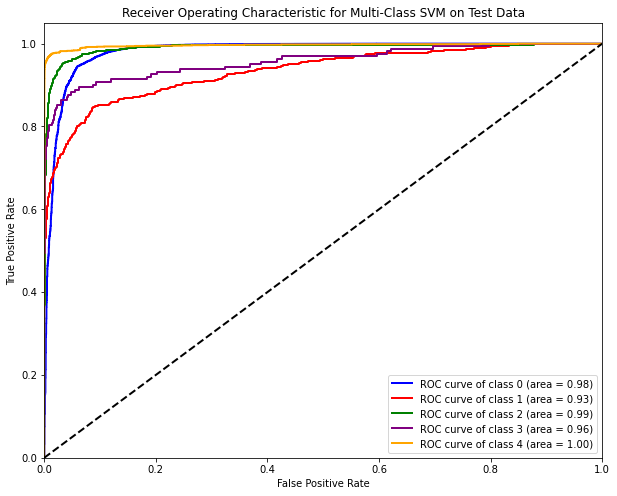

In [49]:
# Creating the ROC curve for SVM model on test set for each class

# Determine the number of classes from y_test
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize the labels for one-vs-rest computation
y_test_binarized = label_binarize(y_test, classes=classes)

# Predict probabilities for each class using the trained SVM model
y_test_score = bestmodel_svm.predict_proba(X_test_pca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class SVM on Test Data')
plt.legend(loc="lower right")
plt.show()

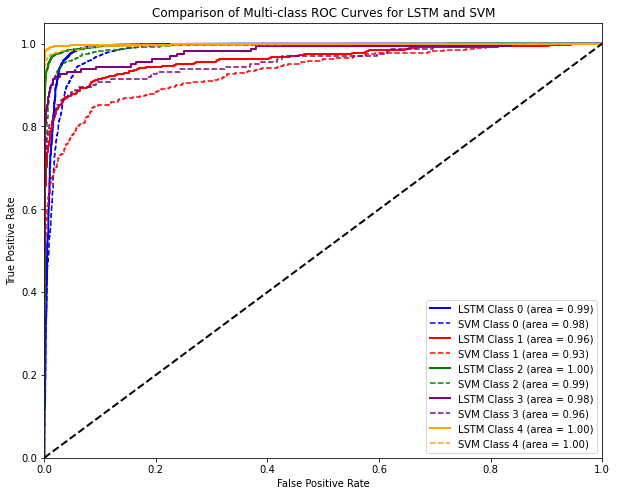

In [53]:
# Creating ROC curve combining the results of both LSTM and SVM to compaare

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# For LSTM: probabilities, all_labels
# For SVM: y_test_score, y_test

# Binarize the labels
n_classes = 5  # Number of classes
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
y_true = label_binarize(all_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class for LSTM
fpr_lstm = {}
tpr_lstm = {}
roc_auc_lstm = {}
for i in range(n_classes):
    fpr_lstm[i], tpr_lstm[i], _ = roc_curve(y_true[:, i], probabilities[:, i])
    roc_auc_lstm[i] = auc(fpr_lstm[i], tpr_lstm[i])

# Compute ROC curve and ROC area for each class for SVM
fpr_svm = {}
tpr_svm = {}
roc_auc_svm = {}
for i in range(n_classes):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_binarized[:, i], y_test_score[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_lstm[i], tpr_lstm[i], color=color, linestyle='-', lw=2,
             label=f'LSTM Class {i} (area = {roc_auc_lstm[i]:.2f})')
    plt.plot(fpr_svm[i], tpr_svm[i], color=color, linestyle='--', lw=1.5,
             label=f'SVM Class {i} (area = {roc_auc_svm[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Multi-class ROC Curves for LSTM and SVM')
plt.legend(loc="lower right")
plt.show()

The LSTM model outperforms the SVM model on the test dataset, achieving a higher overall accuracy of 96.30% compared to 92.26% for SVM. This superior performance is especially noticeable in the precision and recall metrics across minority classes (Class 1, Class 3), where LSTM shows significantly better balance between recognizing positive class instances and the precision of its predictions. The LSTM's ability to effectively capture temporal dependencies in the ECG data likely contributes to its enhanced performance over SVM, which, despite its strong performance in certain classes, shows variability in handling class imbalances effectively.